# Principal Component Analysis

Python functions for performing PCA of climate data fields. Functions include Empirical Orthogonal Function (EOF) analysis, Extended EOF analysis (a.k.a Singular Spectrum Analysis), and Nonlinear Laplacian Spectral Analysis (NLSA)

In [1]:
import numpy as np
from mpl_toolkits.basemap import Basemap
from scipy import stats
from netCDF4 import Dataset
from scipy.interpolate import griddata

%matplotlib inline

m = Basemap(projection='robin',lon_0=-180,resolution='l')

plot_lon,plot_lat = np.meshgrid(np.arange(0,362,2),np.arange(90,-90,-2))
plot_x,plot_y = m(plot_lon,plot_lat)

def readSST():
    SST = {}
    file = Dataset("/Users/williamgregory/Documents/PhD/Datasets/HadISST/HadISST_sst.nc")

    data = np.array(file['sst']).transpose(1,2,0).reshape(180,360,12,2020-1870+1,order='F')
    data[data<0] = np.nan
    lon,lat = np.meshgrid(np.array(file['longitude']),np.array(file['latitude']))
    x,y = m(lon,lat)
    SST['lon'],SST['lat'] = np.meshgrid(np.arange(0,360,2),np.arange(90,-90,-2))
    xr,yr = m(SST['lon'],SST['lat'])

    DJF = np.zeros((90,180,2020-1900+1))
    for year in range(1900,2020+1):
        djf = np.nanmean([data[:,:,11,year-1-1870],data[:,:,0,year-1870],data[:,:,1,year-1870]],0)
        DJF[:,:,year-1900] = griddata((x.ravel(),y.ravel()),djf.ravel(),(xr,yr),'linear')
    SST['DJF'] = DJF
    return SST

def detrend():
    dX,dY,dT = SST['DJF'].shape
    detrended = np.zeros(SST['DJF'].shape)*np.nan
    trends = np.zeros((dX,dY,2))
    for i in range(dX):
        for j in range(dY):
            if ~np.isnan(SST['DJF'][i,j,:]).all():
                trend, intercept, r, p, std = stats.linregress(np.arange(dT),SST['DJF'][i,j,:])
                fit = trend*np.arange(dT) + intercept
                trends[i,j,0] = trend
                trends[i,j,1] = intercept
                detrended[i,j,:] = SST['DJF'][i,j,:] - fit

    SST['DJF_dt'] = detrended
    SST['DJF_trend'] = trend

SST = readSST()
detrend()

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/pyPCA.py:17: RuntimeWarning: All-NaN slice encountered
  self.IDs = np.where(np.nanmax(np.abs(self.data),axis=2)>0)
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/pyPCA.py:17: RuntimeWarning: invalid value encountered in greater
  self.IDs = np.where(np.nanmax(np.abs(self.data),axis=2)>0)
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


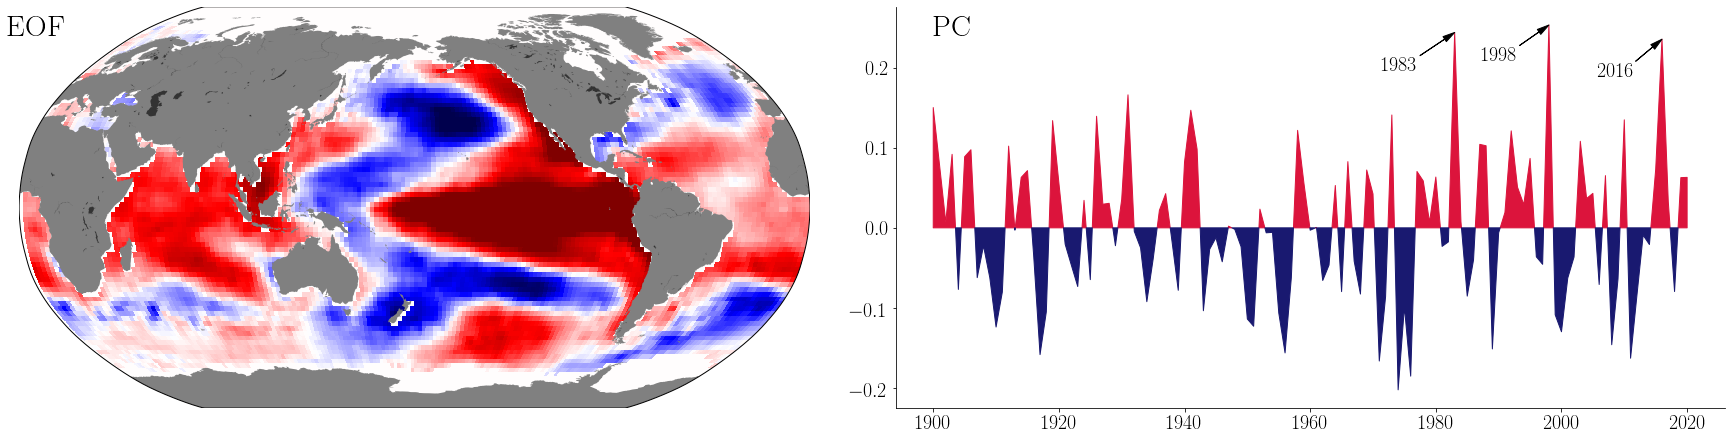

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from pyPCA import PCA

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

SSTPCA = PCA(SST['DJF_dt'],SST['lat'],latlon=True)
PCsEOFA,EOFs = PCA.EOFA(SSTPCA,N=1)

fig,ax = plt.subplots(1,2,figsize=(24,6),constrained_layout=True)
for c in range(2):
    if c == 0:
        m = Basemap(projection='robin',lon_0=-180,resolution='l',ax=ax[c])
        m.fillcontinents(color=(0.5, 0.5, 0.5),lake_color=(0.2, 0.2, 0.2))
        s = m.pcolormesh(plot_x,plot_y,EOFs[:,:,0],cmap='seismic',vmin=-0.02,vmax=0.02,rasterized=True)
        ax[c].text(-.5e6,1.6e7,'EOF',fontsize=30)
    else:
        ax[c].spines['top'].set_color('none')
        ax[c].spines['right'].set_color('none')
        ax[c].fill_between(np.arange(1900,2020+1),PCsEOFA[:,0],0,where=PCsEOFA[:,0]>=0,interpolate=True,color='crimson', rasterized=True)
        ax[c].fill_between(np.arange(1900,2020+1),PCsEOFA[:,0],0,where=PCsEOFA[:,0]<=0,interpolate=True,color='midnightblue', rasterized=True)
        ax[c].annotate('1983', xy=(1983, PCsEOFA[:,0][1983-1900]),  xycoords='data',
                    xytext=(0.63, 0.875), textcoords='axes fraction',
                    arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
                    horizontalalignment='right', verticalalignment='top',
                    )
        ax[c].annotate('1998', xy=(1998, PCsEOFA[:,0][1998-1900]),  xycoords='data',
                    xytext=(0.75, 0.9), textcoords='axes fraction',
                    arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
                    horizontalalignment='right', verticalalignment='top',
                    )
        ax[c].annotate('2016', xy=(2016, PCsEOFA[:,0][2016-1900]),  xycoords='data',
                    xytext=(0.89, 0.86), textcoords='axes fraction',
                    arrowprops=dict(facecolor='black', width=0.1,headwidth=6),
                    horizontalalignment='right', verticalalignment='top',
                    )
        ax[c].text(1900,0.24,'PC',fontsize=30)
plt.show()


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


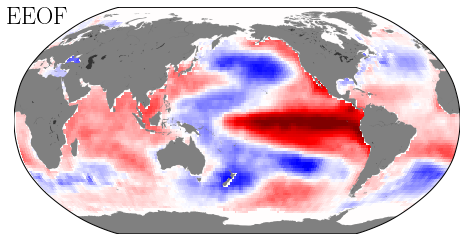

In [3]:
EEOFs = PCA.SSA(SSTPCA,N=1,q=12)

fig,ax = plt.subplots(1,figsize=(8,6))
m = Basemap(projection='robin',lon_0=-180,resolution='l',ax=ax)
m.fillcontinents(color=(0.5, 0.5, 0.5),lake_color=(0.2, 0.2, 0.2))
s = m.pcolormesh(plot_x,plot_y,EEOFs[:,:,2016-1900,0],cmap='seismic',vmin=-0.4,vmax=0.4,rasterized=True)
ax.text(-.5e6,1.6e7,'EEOF',fontsize=24)
plt.show()

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


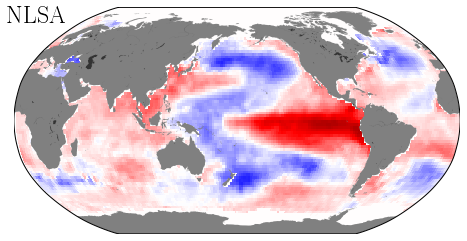

In [4]:
NLSA = PCA.NLSA(SSTPCA,N=1,q=12)

fig,ax = plt.subplots(1,figsize=(8,6))
m = Basemap(projection='robin',lon_0=-180,resolution='l',ax=ax)
m.fillcontinents(color=(0.5, 0.5, 0.5),lake_color=(0.2, 0.2, 0.2))
s = m.pcolormesh(plot_x,plot_y,NLSA[:,:,2016-1900,0],cmap='seismic',vmin=-5e-4,vmax=5e-4,rasterized=True)
ax.text(-.5e6,1.6e7,'NLSA',fontsize=24)
plt.show()